In [1]:
import json
import sys
import numpy as np
sys.path.append('../../')
from util import *
from viz import tableau20
from biasedHypGen_experiment1 import *

# figure settings
AX_LW = .5
AX_COL = (.8, .8, .8)
cc_col = [tableau20[6], tableau20[0]]
cc_pos  = [-.15, .15]

FIGDEST = '../../results_figures/experiment1'
DATADEST = '../../data_proc/experiment1'


def lab(cond, cc):
    """Rule labels based on condition and counterbalance code"""
    
    if cond == 0:
        return ['radius', 'angle'][cc]
    elif cond == 1:
        return ['width', 'height'][cc]
    elif cond == 2:
        return ['positive', 'negative'][cc]
    elif cond == 3:
        return ['positive (shape)', 'negative (size)'][cc]

In [2]:
SUBJ = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, \
        63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, \
        77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, \
        91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, \
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, \
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, \
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, \
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, \
        148, 149, 150, 151, 154, 155, 157, 158, 160, 161, 162, \
        163, 164, 165]

In [28]:
questiondata = pd.read_csv('%s/questiondata.csv' % DATADEST, index_col=0)
conds = [condition(sid) for sid in SUBJ]

print 'Total N:', len(SUBJ)
for c in range(4):
    print 'N(%s): %s' % (COND_LABELS[c], conds.count(c))
    
print '\nAge\n' + '-'*20
print questiondata[questiondata.age!=-1].age.describe()[['mean', 'std']]

print '\nGender\n' + '-'*20
print questiondata['gender'].value_counts()

Total N: 113
N(1D-DIAL): 27
N(1D-RECT): 27
N(2D-DIAL): 29
N(2D-RECT): 30

Age
--------------------
mean    25.486486
std      3.834923
Name: age, dtype: float64

Gender
--------------------
female        67
male          44
noresponse     2
Name: gender, dtype: int64


In [40]:
# Data by block
arr = []
for sid in SUBJ:
    acc = accuracy(sid)
       
    dist_mn = sample_distance_by_block(sid, rescale=True).mean(axis=1)
    dist_med = np.array([np.median(b) for b in sample_distance_by_block(sid, rescale=True)])
    avg_dist_med = np.mean(dist_med) * np.ones(8)

    for block in range(8):
        arr.append([sid, condition(sid), stim_condition(sid), rule_condition(sid), rule_type(sid), block, 
                    acc[block], dist_mn[block], dist_med[block], avg_dist_med[block]])
        
blockdf = pd.DataFrame(arr, columns=['sid', 'cond', 'stimtype', 'ruletype', 'rulevariant',
                                     'block', 'acc', 'dist_mn', 'dist_med', 'avg_dist_med'])
blockdf.to_csv('%s/data_by_block.csv' % DATADEST)

In [41]:
# Data aggregated across blocks
aggdf = blockdf.groupby('sid').agg(np.mean).reset_index()
aggdf['stimtype'] = aggdf['sid'].apply(lambda sid: stim_condition(sid))
aggdf['ruletype'] = aggdf['sid'].apply(lambda sid: rule_condition(sid))
aggdf['rulevariant'] = aggdf['sid'].apply(lambda sid: rule_type(sid))
aggdf.drop('block', 1, inplace=True)
aggdf.to_csv('%s/data_agg.csv' % DATADEST)

# Load data if already created

In [3]:
blockdf = pd.read_csv('%s/data_by_block.csv' % DATADEST)
aggdf = pd.read_csv('%s/data_agg.csv' % DATADEST)

# Classification accuracy

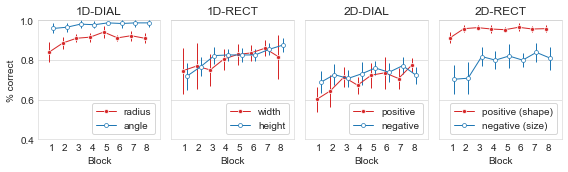

In [45]:
cc_styl = ['-o', '-o']
ms = 4

fig, ax = plt.subplots(1, 4, figsize=(8,2.5), sharey=True)
for i, c in enumerate([0, 1, 2, 3]):
    axi = ax[i]
    
    if c == 0:
        v = ['radius', 'angle']
    elif c == 1:
        v = ['width', 'height']
    elif c == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']
    
    for cc, variant in enumerate(v):
        
        x = np.arange(1, 9) + cc_pos[cc]
        
        conddf = blockdf[(blockdf.cond==c) & (blockdf.rulevariant==variant)]
        m = conddf.groupby('block').apply(lambda d: np.mean(d.acc))        
        CI = within_normalized_CI(conddf, 'block', 'acc', 'sid')['95-CI(within)'].values

        (_, caps, _) = axi.errorbar(x, m.values, yerr=CI, capsize=0,
                                    fmt='o', markersize=0, color=cc_col[cc], linewidth=1)
        #for cap in caps:
        #    cap.set_color(cc_col[cc])
        #    cap.set_markeredgewidth(1)
        
        if cc==0:
            axi.plot(x, m.values, cc_styl[cc], color=cc_col[cc],
                     label=lab(c, cc), markerfacecolor=cc_col[cc],
                     markeredgewidth=.7, markersize=ms, markeredgecolor='white', linewidth=1)
        else:
            axi.plot(x, m.values, cc_styl[cc], color=cc_col[cc],
                     label=lab(c,cc), markerfacecolor='white',
                     markeredgewidth=.7, markersize=ms, markeredgecolor=cc_col[cc], linewidth=1)
    
    axi.set_title(COND_LABELS[c])
    axi.set_ylim(0.4, 1)
    axi.set_xlim(0, 9)
    axi.set_xlabel('Block')
    leg = axi.legend(loc='lower right', frameon=True)
    leg.get_frame().set_edgecolor(AX_COL)
    axi.set_xticks(range(1, 9))
    axi.yaxis.grid(alpha=.7)
    
    for i in axi.spines.itervalues():
        i.set_linewidth(AX_LW)
        i.set_color(AX_COL)

ax[0].set_ylabel('% correct')

#add_letter_label(fig, 0.0, .93, 'A')

plt.tight_layout()
plt.show()
fig.savefig('%s/exp1_accuracy_normCI.pdf' % FIGDEST, bbox_inches='tight')

# Selection distance from boundary

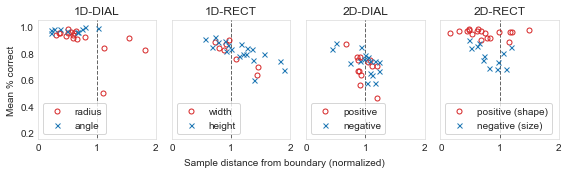

In [20]:
def lab(cond, cc):
    """Rule labels based on condition and counterbalance code"""
    
    if cond == 0:
        return ['radius', 'angle'][cc]
    elif cond == 1:
        return ['width', 'height'][cc]
    elif cond == 2:
        return ['positive', 'negative'][cc]
    elif cond == 3:
        return ['positive (shape)', 'negative (size)'][cc]

cc_col = [tableau20[6], tableau20[0]]

fig, ax = plt.subplots(1, 4, figsize=(8, 2.5), sharey=True)
for c in range(4):
    axi = ax[c]
    ref = 1

    if c == 0:
        v = ['radius', 'angle']
    elif c == 1:
        v = ['width', 'height']
    elif c == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']
    
    axi.plot([ref, ref], [0, 1.1], '--', color='black', alpha=.6, linewidth=1)
    for cc, variant in enumerate(v):

        pts = blockdf[(blockdf.cond==c) &
                      (blockdf.rulevariant==variant)].groupby('sid').apply(lambda d: d[['dist_med', 'acc']].mean()).values
        
        if cc == 0:
            axi.plot(pts[:,0], pts[:,1], 'o', 
                     markeredgecolor=cc_col[cc], markerfacecolor='None', markeredgewidth=1., markersize=5,
                     label=lab(c, cc))
        else:
            axi.plot(pts[:,0], pts[:,1], 'x', 
                     markeredgecolor=cc_col[cc], markerfacecolor='None', markeredgewidth=1., markersize=5,
                     label=lab(c, cc))
   
    if c < 2:
        axi.set_xlim(0, 2)
        axi.set_xticks([0.01, 1, 2])
        axi.set_xticklabels([0, 1, 2])
    else:
        axi.set_xlim(0, 2)
        axi.set_xticks([0.01, 1, 2])
        axi.set_xticklabels([0, 1, 2])
    axi.set_ylim(0.15, 1.05)
    leg = axi.legend(loc='best', frameon=True)  
    leg.get_frame().set_edgecolor(AX_COL)
    
    axi.set_title(COND_LABELS[c])

    axi.set_xlabel('distance', fontdict={'color': 'white'})
    
    for i in axi.spines.itervalues():
        i.set_linewidth(AX_LW)
        i.set_color(AX_COL)


ax[0].set_ylabel('Mean % correct')

fig.text(0.5, .06, 'Sample distance from boundary (normalized)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()
fig.savefig('%s/exp1_sampledistance_x_accuracy.pdf' % FIGDEST, bbox_inches='tight')

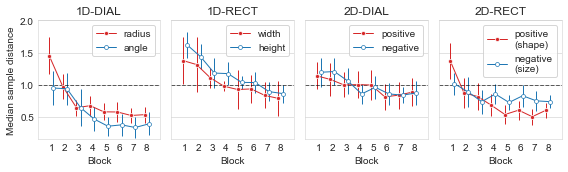

In [47]:
def lab(cond, cc):
    """Rule labels based on condition and counterbalance code"""
    
    if cond == 0:
        return ['radius', 'angle'][cc]
    elif cond == 1:
        return ['width', 'height'][cc]
    elif cond == 2:
        return ['positive', 'negative'][cc]
    elif cond == 3:
        return ['positive\n(shape)', 'negative\n(size)'][cc]

cc_styl = ['-o', '-o']
ms = 4

fig, ax = plt.subplots(1, 4, figsize=(8,2.5), sharey=True)
for i, c in enumerate([0, 1, 2, 3]):
    axi = ax[i]
    
    if c == 0:
        v = ['radius', 'angle']
    elif c == 1:
        v = ['width', 'height']
    elif c == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']
        
    axi.plot([0, 9], [1, 1], '--', color='black', alpha=.6, linewidth=1)
    
    for cc, variant in enumerate(v):
        
        x = np.arange(1, 9) + cc_pos[cc]
        
        conddf = blockdf[(blockdf.cond==c) & (blockdf.rulevariant==variant)]
        m = conddf.groupby('block').apply(lambda d: np.mean(d.dist_med))        
        CI = within_normalized_CI(conddf, 'block', 'dist_med', 'sid')['95-CI(within)'].values

        (_, caps, _) = axi.errorbar(x, m.values, yerr=CI, capsize=0,
                                    fmt='o', markersize=0, color=cc_col[cc], linewidth=1)
        #for cap in caps:
        #    cap.set_color(cc_col[cc])
        #    cap.set_markeredgewidth(1)
        
        if cc==0:
            axi.plot(x, m.values, cc_styl[cc], color=cc_col[cc],
                     label=lab(c, cc), markerfacecolor=cc_col[cc],
                     markeredgewidth=.7, markersize=ms, markeredgecolor='white', linewidth=1)
        else:
            axi.plot(x, m.values, cc_styl[cc], color=cc_col[cc],
                     label=lab(c,cc), markerfacecolor='white',
                     markeredgewidth=.7, markersize=ms, markeredgecolor=cc_col[cc], linewidth=1)
    
    axi.set_title(COND_LABELS[c])
    axi.set_ylim(0.15, 2)
    axi.set_xlim(0, 9)
    axi.set_xlabel('Block')
    leg = axi.legend(loc='upper right', frameon=True)
    leg.get_frame().set_edgecolor(AX_COL)
    axi.set_xticks(range(1, 9))
    axi.yaxis.grid(alpha=.7)
    
    for i in axi.spines.itervalues():
        i.set_linewidth(AX_LW)
        i.set_color(AX_COL)

ax[0].set_ylabel('Median sample distance')

#add_letter_label(fig, 0.0, .93, 'A')

plt.tight_layout()
plt.show()
fig.savefig('%s/exp1_sampledistance_by_block_normCI.pdf' % FIGDEST, bbox_inches='tight')

# Modeling classification boundaries

In [14]:
# save classification data to csv
for sid in SUBJ:
    for block in range(8):
        tdf = pd.DataFrame(testdata(sid, block), columns=['x1', 'x2', 'resp', 'correct'])
        tdf['resp'] = map(lambda r: 0. if r=='A' else 1., tdf['resp'].values)
        tdf.to_csv('%s/testdata/testdata_%s_%s.csv' % (DATADEST, sid, block))

In [32]:
# load results
arr = []
for sid in SUBJ:
    for block in range(8):
        fitresult = pd.read_csv('%s/fit_boundaries/fit_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        fitresultx1 = pd.read_csv('%s/fit_boundaries/fitx1_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        fitresultx2 = pd.read_csv('%s/fit_boundaries/fitx2_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        
        arr.append([sid, condition(sid), rule_counter(sid), rule_type(sid), block, 
                    fitresult.loc['(Intercept)']['Estimate'],
                    fitresult.loc['x1']['Estimate'],
                    fitresult.loc['x2']['Estimate'],
                    fitresultx1.loc['(Intercept)']['Estimate'],
                    fitresultx1.loc['x1']['Estimate'],
                    1e-4,
                    fitresultx2.loc['(Intercept)']['Estimate'],
                    1e-4,
                    fitresultx2.loc['x2']['Estimate']])
fitdf = pd.DataFrame(arr, columns=['sid', 'cond', 'counter', 'rulevariant', 'block', 
                                   'c_int', 'c_x1', 'c_x2',
                                   'f1_c_int', 'f1_c_x1', 'f1_c_x2',
                                   'f2_c_int', 'f2_c_x1', 'f2_c_x2',
                                   ])
fitdf['intercept'] = -fitdf.c_int/fitdf.c_x2
fitdf['slope'] = -fitdf.c_x1/fitdf.c_x2

fitdf['x1_intercept'] = -fitdf.f1_c_int/fitdf.f1_c_x2
fitdf['x1_slope'] = -fitdf.f1_c_x1/fitdf.f1_c_x2

fitdf['x2_intercept'] = -fitdf.f2_c_int/fitdf.f2_c_x2
fitdf['x2_slope'] = 0

fitdf['2drule'] = 1 * ((np.abs(fitdf.slope) > .25) & (np.abs(fitdf.slope) < 4))
#fitdf['2drule_pos'] = 1 * ((fitdf.slope > .25) & (fitdf.slope < 4))
#fitdf['2drule_neg'] = 1 * ((fitdf.slope < -.25) & (fitdf.slope > -4))
fitdf['2drule_pos'] = 1 * (fitdf.slope > 0)
fitdf['2drule_neg'] = 1 * (fitdf.slope < 0)

In [33]:
# load results for comparison to null model
arr = []
for sid in SUBJ:
    for block in range(8):
        comp_result = pd.read_csv('%s/fit_boundaries/fit_comp_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        try:
            arr.append([comp_result.loc[1,'x'], comp_result.loc[2,'x'], comp_result.loc[3,'x'], comp_result.loc[4,'x']])
        except:
            print sid
            print comp_result
arr = np.array(arr)

fitdf['aic'] = arr[:,0]
fitdf['aic_x1'] = arr[:,1]
fitdf['aic_x2'] = arr[:,2]
fitdf['aic_null'] = arr[:,3]
fitdf['2drule_aic'] = 1*(fitdf['aic'] < fitdf['aic_x1']) & (fitdf['aic'] < fitdf['aic_x2']) & (fitdf['aic'] < fitdf['aic_null'])
fitdf['2drule_pos_aic'] = 1*fitdf['2drule_aic']*(fitdf.slope > 0)
fitdf['2drule_neg_aic'] = 1*fitdf['2drule_aic']*(fitdf.slope < 0)

In [34]:
# find cases where baseline model was best
failed = fitdf[(fitdf['aic_null'] < fitdf['aic']) & 
               (fitdf['aic_null'] < fitdf['aic_x1']) & 
               (fitdf['aic_null'] < fitdf['aic_x2'])].shape[0]
print 'baseline was better for: %s blocks (%s percent)' % (failed, failed/float(fitdf.shape[0]))

baseline was better for: 37 blocks (0.0409292035398 percent)


In [35]:
def orthogonal_distance(pt, f1, f2):
    x0, y0 = pt
    x1, y1 = f1
    x2, y2 = f2
    return np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2*y1 - y2*x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

arr = []
for i, row in fitdf.iterrows():
    
    best = np.argmin(row[['aic', 'aic_x1', 'aic_x2', 'aic_null']].values)
    if best == 0:
        intercept = row.intercept
        slope = row.slope
    elif best == 1:
        intercept = row.x1_intercept
        slope = row.x1_slope
    elif best == 2:
        intercept = row.x2_intercept
        slope = row.x2_slope

    arr.append(orthogonal_distance([.5, .5], [0, intercept], [1, intercept + slope]))
fitdf['deviation'] = np.array(arr)

In [19]:
propdf = fitdf.groupby('sid').agg(np.mean).reset_index()[['sid', 'cond', 'counter', '2drule', '2drule_aic']]
st = []
rt = []
rv = []
for i, row in propdf.iterrows():
    sid = int(row['sid'])
    f = aggdf[aggdf.sid==sid].iloc[0]
    st.append(f.stimtype)
    rt.append(f.ruletype)
    rv.append(f.rulevariant)

propdf['stimtype'] = st
propdf['ruletype'] = rt
propdf['rulevariant'] = rv
propdf.to_csv('%s/prop2d.csv' % DATADEST)

In [36]:
p2d = {}
for cond in range(4):
    if cond == 0:
        v = ['radius', 'angle']
    elif cond == 1:
        v = ['width', 'height']
    elif cond == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']

    for variant in v:
        p2d[(cond, variant)] = [fitdf[(fitdf.cond==cond) & 
                                      (fitdf.block==block) & 
                                      (fitdf.rulevariant==variant)]['2drule_aic'].mean() \
                           for block in range(8)]

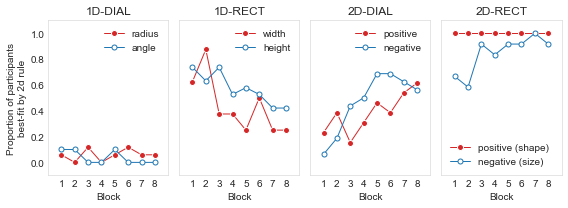

In [37]:
cc_col = [tableau20[6], tableau20[0]]
cc_styl = ['-o', '-o']
ms = 5

leg_loc = ['upper right', 'upper right', 'lower right', 'lower left']

fig, ax = plt.subplots(1, 4, figsize=(8, 3), sharey=True)
for cond in range(4):
    axi = ax[cond]
    if cond == 0:
        v = ['radius', 'angle']
    elif cond == 1:
        v = ['width', 'height']
    elif cond == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']

    for cc, variant in enumerate(v):
        if cc==0:
            axi.plot(range(1, 9), p2d[(cond, variant)], cc_styl[cc], label=dim_label(cond, cc), 
                     color=cc_col[cc], linewidth=1, markerfacecolor=cc_col[cc],
                     markeredgewidth=1, markersize=ms+1, markeredgecolor='white')
        else:
            axi.plot(range(1, 9), p2d[(cond, variant)], cc_styl[cc], label=dim_label(cond, cc), 
                     color=cc_col[cc], linewidth=1, markerfacecolor='white', markeredgecolor=cc_col[cc],
                     markeredgewidth=1, markersize=ms)


    axi.set_ylim(-.1, 1.1)
    axi.set_xlim(0, 9)
    axi.legend(loc='best')
    axi.set_xticks(range(1, 9))
    axi.set_xlabel('Block')
    axi.set_title(COND_LABELS[cond])
    for i in axi.spines.itervalues():
        i.set_linewidth(AX_LW)
        i.set_color(AX_COL)

ax[0].set_ylabel('Proportion of participants\nbest-fit by 2d rule')
plt.tight_layout()
plt.show()
fig.savefig('%s/exp1_prop_2d_rules.pdf' % FIGDEST, bbox_inches='tight')

In [19]:
p2d = {}
for cond in range(4):
    if cond == 0:
        v = ['radius', 'angle']
    elif cond == 1:
        v = ['width', 'height']
    elif cond == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']

    for variant in v:
        p2d[(cond, variant)] = [fitdf[(fitdf.cond==cond) & 
                                      (fitdf.block==block) & 
                                      (fitdf.rulevariant==variant)]['2drule_aic'].mean() \
                           for block in range(8)]

In [20]:
p2d_pos = {}
p2d_neg = {}
for cond in range(4):
    if cond == 0:
        v = ['radius', 'angle']
    elif cond == 1:
        v = ['width', 'height']
    elif cond == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']

    for variant in v:

        p2d_pos[(cond, variant)] = [fitdf[(fitdf.cond==cond) & 
                                     (fitdf.block==block) & 
                                     (fitdf.rulevariant==variant)]['2drule_pos_aic'].mean() \
                           for block in range(8)]
        p2d_neg[(cond, variant)] = [fitdf[(fitdf.cond==cond) & 
                                     (fitdf.block==block) & 
                                     (fitdf.rulevariant==variant)]['2drule_neg_aic'].mean() \
                           for block in range(8)]

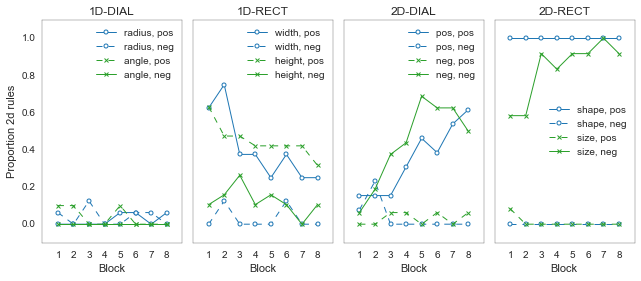

In [24]:
cc_col = [tableau20[0], tableau20[4]]
cc_styl = ['-o', '--']
cc_alpha = [1., 1.]
ms = 4

col = [[tableau20[0], tableau20[0]], [tableau20[4], tableau20[4]]]
styl = [['-o', '--o'], ['--x', '-x']]

fig, ax = plt.subplots(1, 4, figsize=(9,4), sharey=True)
for i, cond in enumerate([0, 1, 2, 3]):
    axi = ax[i]
    
    if cond == 0:
        v = ['radius', 'angle']
    elif cond == 1:
        v = ['width', 'height']
    elif cond == 2:
        v = ['pos', 'neg']
    else:
        v = ['shape', 'size']

    for cc, variant in enumerate(v):

        axi.plot(range(1, 9), p2d_pos[(cond, variant)], styl[cc][0], label=(dim_label(cond, cc) + ', pos'), 
                 color=col[cc][0], alpha=cc_alpha[cc], linewidth=1,
                 markersize=ms, markerfacecolor='white', markeredgecolor=col[cc][0], markeredgewidth=1)
        axi.plot(range(1, 9), p2d_neg[(cond, variant)], styl[cc][1], label=(dim_label(cond, cc) + ', neg'), 
                 color=col[cc][1], alpha=cc_alpha[cc], linewidth=1,
                markersize=ms, markerfacecolor='white', markeredgecolor=col[cc][1], markeredgewidth=1)


    #axi.set_title(COND_LABELS[cond])
    axi.set_ylim(-.1, 1.1)
    axi.set_xlim(0, 9)
    axi.legend(loc='best')
    axi.set_xticks(range(1, 9))
    axi.set_xlabel('Block')
    axi.set_title(COND_LABELS[cond])
    for i in axi.spines.itervalues():
        i.set_linewidth(0.3)


ax[0].set_ylabel('Proportion 2d rules')

plt.tight_layout()
plt.show()
#fig.savefig(FIGDEST+'exp1_prop_2d_rules.pdf', bbox_inches='tight')

# Best fit boundaries based on selection (training) data

In [7]:
# save training data (selections) to csv
for sid in SUBJ:
    for block in range(8):
        arr = [[x[0], x[1], y] for x, y in zip(selections(sid, block), selection_feedback(sid, block))]
        tdf = pd.DataFrame(arr, columns=['x1', 'x2', 'resp'])
        tdf['resp'] = map(lambda r: 0. if r=='A' else 1., tdf['resp'].values)
        tdf.to_csv('%s/traindata/traindata_%s_%s.csv' % (DATADEST, sid, block))

In [20]:
# read back in fits
arr = []
for sid in SUBJ:
    for block in range(8):
        fitresult = pd.read_csv('%s/fit_boundaries/fit_training_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        arr.append([sid, condition(sid), rule_counter(sid), block, 
                    fitresult.loc['(Intercept)']['Estimate'],
                    fitresult.loc['x1']['Estimate'],
                    fitresult.loc['x2']['Estimate'],
                    fitresult.loc['x1']['Pr(>|z|)'],
                    fitresult.loc['x2']['Pr(>|z|)']])

fitdf = pd.DataFrame(arr, columns=['sid', 'cond', 'counter', 'block', 
                                   'c_int', 'c_x1', 'c_x2',
                                   'p_x1', 'p_x2'])
fitdf['intercept'] = -fitdf.c_int/fitdf.c_x2
fitdf['slope'] = -fitdf.c_x1/fitdf.c_x2
fitdf['2drule'] = 1 * ((np.abs(fitdf.slope) > .25) & (np.abs(fitdf.slope) < 4))

In [22]:
# load results for comparison to null model
arr = []
for sid in SUBJ:
    for block in range(8):
        comp_result = pd.read_csv('%s/fit_boundaries/fit_training_comp_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        try:
            arr.append([comp_result.loc[1,'x'], comp_result.loc[2,'x'], comp_result.loc[3,'x']])
        except:
            print sid
            print comp_result
arr = np.array(arr)

fitdf['aic'] = arr[:,0]
fitdf['aic_x1'] = arr[:,1]
fitdf['aic_x2'] = arr[:,2]
fitdf['2drule_aic'] = 1*(fitdf['aic'] < fitdf['aic_x1']) & (fitdf['aic'] < fitdf['aic_x2'])
#fitdf['2drule_pos_aic'] = 1*fitdf['2drule_aic']*(fitdf.slope > 0)
#fitdf['2drule_neg_aic'] = 1*fitdf['2drule_aic']*(fitdf.slope < 0)

p2d_train = {}
for cond in range(4):
    for cc in [0, 1]:
        p2d_train[(cond, cc)] = [fitdf[(fitdf.cond==cond) & (fitdf.block==block) & (fitdf.counter%2==cc)]['2drule_aic'].mean() \
                           for block in range(8)]

In [25]:
print 'Proportion 2D rules based on training selections'
for cond in range(4):
    print COND_LABELS[cond], np.mean([p2d_train[(cond,0)], p2d_train[(cond,1)]])

Proportion 2D rules based on training selections
1D-DIAL 0.0281593406593
1D-RECT 0.0
2D-DIAL 0.872295673077
2D-RECT 0.859375
